In [13]:
# Import useful python packages
import numpy as np

# Import packages to display images inline in the notebook
import matplotlib.pyplot as plt    
%matplotlib inline   

# Set general plotting options
params = {'legend.fontsize': '18', 'axes.labelsize': '18',
          'axes.titlesize': '18', 'xtick.labelsize': '18',
          'ytick.labelsize': '18', 'lines.linewidth': 2, 'axes.linewidth': 2, 'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

In [14]:
# Import astropy packages 
from astropy import units as u
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.table import Table, vstack
from astropy.stats import sigma_clipped_stats
from astropy.nddata import StdDevUncertainty
from astropy.io import fits # added by BAS on 8 April 2021
from astropy.utils.data import get_pkg_data_filename
from astropy.utils.data import download_file

# To find stars in the MRS spectralcubes and do aperture photometry
from photutils import DAOStarFinder, CircularAperture

# To deal with 1D spectrum
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum
from specutils.manipulation import box_smooth, extract_region, SplineInterpolatedResampler
from specutils.analysis import line_flux, centroid, equivalent_width
from specutils.spectra import SpectralRegion
from specutils import SpectrumList
from jdaviz import Specviz
from jdaviz import Cubeviz

# To fit a curve to the data
from scipy.optimize import curve_fit


In [15]:
# Save and Load Objects Using Pickle
import pickle


def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


In [16]:
def checkKey(dict, key):
      
    if key in dict.keys():
        print("Present, ", end=" ")
        print("value =", dict[key])
        return(True)
    else:
        print("Not present")
        return(False)

In [17]:
import warnings
warnings.simplefilter('ignore')

In [18]:
import os
os.chdir("/Users/liorshefler/Documents/Fall2022/Research/MAST_2022-09-07T1447/JWST/jw01386-o015_t005_miri_ch1-mediumshortlong-")

In [19]:
# Read in all X1D spectra to a single spectrum list and combine into a single spectrum1d object

ddd = '.'
splist = SpectrumList.read(ddd)

wlallorig = []
fnuallorig = []
dfnuallorig = []
for bndind in range(len(splist)):
    for wlind in range(len(splist[bndind].spectral_axis)):
        wlallorig.append(splist[bndind].spectral_axis[wlind].value)
        fnuallorig.append(splist[bndind].flux[wlind].value)
        dfnuallorig.append(splist[bndind].uncertainty[wlind].array)

wlallarr = np.array(wlallorig)
fnuallarr = np.array(fnuallorig)
dfnuallarr = np.array(dfnuallorig)
srtind = np.argsort(wlallarr)
wlall = wlallarr[srtind]
fnuall = fnuallarr[srtind]

# Developer Note: We put in errors of 0.0001, but uncertainties need to be fixed
dfnuall = (0.0001)*np.ones(len(fnuall))

In [20]:
# Open these spectra up in Specviz
specviz = Specviz()
specviz.app

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

In [21]:
# Load in the spectrum list from above. 
specviz.load_spectrum(splist)

In [22]:
cubeviz = Cubeviz()
cubeviz.app

Application(config='cubeviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

In [23]:
# Here, we load the data into the Cubeviz app for visual inspection.  
# In this case, we're just looking at a single channel because, unlike Specviz, Cubeviz can only load a single cube at a time.

ch1short_cubefile = 'jw01386-o015_t005_miri_ch1-mediumshortlong-_s3d.fits'
cubeviz.load_data(ch1short_cubefile)

# Too noisy, cannot locate target

Could be due to:
- Exoplanet's proximity to star
- Dimness of exoplanet

In [24]:
# Now extract spectrum from your spectral viewer
spec_agb = cubeviz.app.get_data_from_viewer('spectrum-viewer', 'Subset 5') # AGB star only

In [25]:
wav = wlall*u.micron # Wavelength: microns
fl = fnuall*u.Jy # Fnu:  Jy
efl = dfnuall*u.Jy # Error flux: Jy

# Make a 1D spectrum object
spec = Spectrum1D(spectral_axis=wav, flux=fl, uncertainty=StdDevUncertainty(efl))

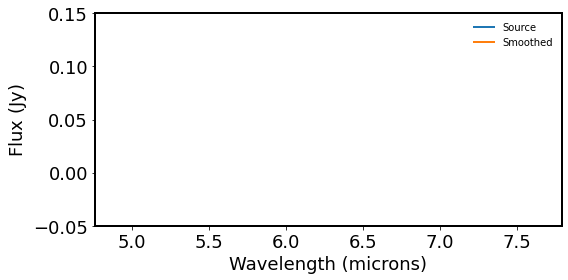

In [26]:
# Apply a 5 pixel boxcar smoothing to the spectrum
spec_bsmooth = box_smooth(spec, width=5)   

# Plot the spectrum & smoothed spectrum to inspect features 
plt.figure(figsize=(8, 4))
plt.plot(spec.spectral_axis, spec.flux, label='Source')
plt.plot(spec.spectral_axis, spec_bsmooth.flux, label='Smoothed')
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.ylim(-0.05, 0.15)


plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

In [27]:
spec_agb = spec


In [28]:
# Open these spectra up in Specviz
specviz = Specviz()
specviz.app

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

In [29]:
# For now, you must create your own spectrum1d object from your extracted cubeviz spectrum.  
flux = spec_agb.flux
wavelength = spec_agb.spectral_axis
spec1d = Spectrum1D(spectral_axis=wavelength, flux=flux)
specviz.load_spectrum(spec1d)